## Fixed and Injected Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

fwhm = 5 # full-width half maximum, which will be determined from well-isolated stars
box_size = 15 # the number of pixels (width and height) of the region being fitted

# The injected parameters

(
    a1,
    ax, ay,
    axx, axy, ayy,
    h_injected, x_injected, y_injected,
) = (
    15.0,
    5.5, 10.5,
    -15.5, 15.5, 12.5,
    50.0, 4.4, 6.5
)

## Make Fake Data

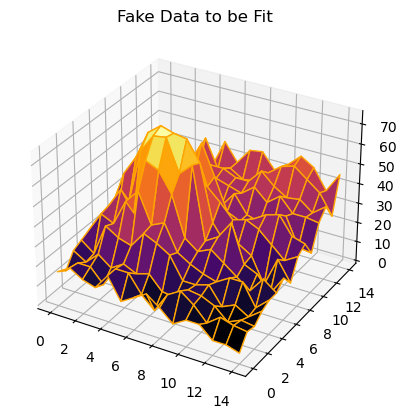

In [2]:
sigma_squared = (fwhm / 2)**2 / math.log(2)

def centered_seeing_function(x, y):
    distance_squared = x**2 + y**2
    return math.exp(-distance_squared / sigma_squared)

def make_model(background, x_slope, y_slope, axx, axy, ayy, height, x_pos, y_pos):
    def model(x, y):
        return (
            background +
            x_slope * x / box_size +
            y_slope * y / box_size +
            axx * x**2 / box_size**2 +
            axy * x * y / box_size**2 +
            ayy * y**2 / box_size**2 +
            height * centered_seeing_function(x - x_pos, y - y_pos)
        )

    return model

data_generator = make_model(a1, ax, ay, axx, axy, ayy, h_injected, x_injected, y_injected)

x_positions = range(box_size)
y_positions = range(box_size)

samples = [[np.random.poisson(data_generator(i, j)) for i in x_positions] for j in y_positions]

x = np.outer(x_positions, np.ones(box_size)).T
y = np.outer(y_positions, np.ones(box_size))
data = np.array(samples)
 
fig = plt.figure()
 
# syntax for 3-D plotting
axes = plt.axes(projection='3d')
axes.plot_surface(x, y, data, cmap='inferno', edgecolor='orange')
axes.set_title('Fake Data to be Fit')
axes.axes.set_zlim3d(bottom=0, top=75)

plt.show()

# The numpy convention when converting a nested list to an array is
# that the most-rapidly varying index stays last, which sort of makes sense.
#
# To be concrete, samples[int(y_injected)][int(x_injected)] will be near the peak:
#
# intx = int(x_injected)
# inty = int(y_injected)
#
# (samples[inty][intx], data[inty, intx], h_injected)
#
# The above few lines will reveal values that are nearly h_injected plus background and noise

## Use scipy.optimize to &ldquo;Discover&rdquo; the Peak in this &ldquo;Data&rdquo;

In [3]:
def variance(model, data):
    shape = data.shape
    sum = 0.0
    for j in range(shape[0]):
        for i in range(shape[1]):
            difference = model(i, j) - data[j, i]
            sum += difference**2
    return sum


In [4]:
BACKGROUND_PARAMETER_INDEX = 0
LINX_SLOPE_PARAMETER_INDEX = 1
LINY_SLOPE_PARAMETER_INDEX = 2
QUDXX_COEF_PARAMETER_INDEX = 3
QUDXY_COEF_PARAMETER_INDEX = 4
QUDYY_COEF_PARAMETER_INDEX = 5
PEAK_PIXEL_PARAMETER_INDEX = 6
POSITION_X_PARAMETER_INDEX = 7
POSITION_Y_PARAMETER_INDEX = 8

def objective_function(model_parameters, data):
    background = model_parameters[BACKGROUND_PARAMETER_INDEX]
    linx_slope = model_parameters[LINX_SLOPE_PARAMETER_INDEX]
    liny_slope = model_parameters[LINY_SLOPE_PARAMETER_INDEX]
    qudxx_coef = model_parameters[QUDXX_COEF_PARAMETER_INDEX]
    qudxy_coef = model_parameters[QUDXY_COEF_PARAMETER_INDEX]
    qudyy_coef = model_parameters[QUDYY_COEF_PARAMETER_INDEX]
    peak_pixel = model_parameters[PEAK_PIXEL_PARAMETER_INDEX]
    position_x = model_parameters[POSITION_X_PARAMETER_INDEX]
    position_y = model_parameters[POSITION_Y_PARAMETER_INDEX]
    model = make_model(background,
                       linx_slope, liny_slope,
                       qudxx_coef, qudxy_coef, qudyy_coef,
                       peak_pixel, position_x, position_y)
    return variance(model, data)


## Make our Initial Guesses

In [5]:
background0 = np.median(data)
# background0 = 1.0
linx_slope0 = 0.0
liny_slope0 = 0.0
qudxx_coef0 = 0.0
qudxy_coef0 = 0.0
qudyy_coef0 = 0.0
peak_pixel0 = 25.0
position_x0 = 7.0
position_y0 = 7.0

x0 = (background0,
      linx_slope0, liny_slope0,
      qudxx_coef0, qudxy_coef0, qudyy_coef0,
      peak_pixel0, position_x0, position_y0,)

In [6]:
from scipy.optimize import minimize

result = minimize(objective_function, x0=x0, args=(data,)).x

background = result[BACKGROUND_PARAMETER_INDEX]
linx_slope = result[LINX_SLOPE_PARAMETER_INDEX]
liny_slope = result[LINY_SLOPE_PARAMETER_INDEX]
qudxx_coef = result[QUDXX_COEF_PARAMETER_INDEX]
qudxy_coef = result[QUDXY_COEF_PARAMETER_INDEX]
qudyy_coef = result[QUDYY_COEF_PARAMETER_INDEX]
peak_pixel = result[PEAK_PIXEL_PARAMETER_INDEX]
position_x = result[POSITION_X_PARAMETER_INDEX]
position_y = result[POSITION_Y_PARAMETER_INDEX]

## Compare the Injected Values with the &ldquo;Discovered&rdquo; Ones

In [7]:
(
    (background, linx_slope, liny_slope, qudxx_coef, qudxy_coef, qudyy_coef, peak_pixel, position_x, position_y),
     'vs.',
    (a1, ax, ay, axx, axy, ayy, h_injected, x_injected, y_injected)
)

# What we care the most about (the accuracy of the determined value of the peak) is the third-from-last
# value in the tuples.

((15.798125450088653,
  6.540593186199179,
  3.8637181145204216,
  -19.375901927034008,
  21.753315022831238,
  16.780701828910228,
  51.48931636984674,
  4.471694473652238,
  6.577125329729638),
 'vs.',
 (15.0, 5.5, 10.5, -15.5, 15.5, 12.5, 50.0, 4.4, 6.5))